In this notebook, everything is same as the previous one except I overwrote a few classes and functions of fastai to add the Atrous Convolution and CRF layer. I particulary changed the middle convolutions to atrous convolutions and added a CRF layer at the end. But this notebook shows the results with only the Atrous Convolutions change because training this model twice(once for the previous notebook) took almost 12 hrs and I didnt get time to show the results of the model with CRF, but my changes are well integrated in the FastAi classes as I ran and checked, I just cant make comment on the results with the CRF.

In [1]:
import fastai
from fastai import *
from fastai.vision import *

import pathlib
import os
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
fastai.__version__

'1.0.61'

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())
import os
os.chdir("/content/drive/MyDrive")

Below is the implementation of atrous convolution. I took the normal convolution's code form fastai and added the dilations part to it

In [4]:
def conv_layer_atrous(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias:bool=None, dilation:int=1,is_1d:bool=False,
               norm_type:Optional[NormType]=NormType.Batch,  use_activ:bool=True, leaky:float=None,
               transpose:bool=False, init:Callable=nn.init.kaiming_normal_, self_attention:bool=False):
    "Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and batchnorm (if `bn`) layers."
    if padding is None: padding = (((ks-1) + (ks-1)*(dilation-1)) // 2 if not transpose else 0)
    bn = norm_type in (NormType.Batch, NormType.BatchZero)
    inn = norm_type in (NormType.Instance, NormType.InstanceZero)
    if bias is None: bias = not (bn or inn)
    conv_func = _conv_func(ndim, transpose=transpose)
    conv = init_default(conv_func(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding, dilation=dilation, **kwargs), init)
    if   norm_type==NormType.Weight:   conv = weight_norm(conv)
    elif norm_type==NormType.Spectral: conv = spectral_norm(conv)
    layers = [conv]
    if use_activ: layers.append(relu(True, leaky=leaky))
    if bn: layers.append((nn.BatchNorm1d if is_1d else nn.BatchNorm2d)(nf))
    if self_attention: layers.append(SelfAttention(nf))
    return nn.Sequential(*layers)

In [5]:
os.chdir("/content/drive/MyDrive")

In [ ]:
!tar -xvf  'VOCtrainval_11-May-2012.tar' -C 'zipped_VOC/'

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2012/SegmentationClass/2008_001874.png
VOCdevkit/VOC2012/SegmentationClass/2008_001876.png
VOCdevkit/VOC2012/SegmentationClass/2008_001882.png
VOCdevkit/VOC2012/SegmentationClass/2008_001885.png
VOCdevkit/VOC2012/SegmentationClass/2008_001895.png
VOCdevkit/VOC2012/SegmentationClass/2008_001896.png
VOCdevkit/VOC2012/SegmentationClass/2008_001926.png
VOCdevkit/VOC2012/SegmentationClass/2008_001966.png
VOCdevkit/VOC2012/SegmentationClass/2008_001971.png
VOCdevkit/VOC2012/SegmentationClass/2008_001992.png
VOCdevkit/VOC2012/SegmentationClass/2008_001997.png
VOCdevkit/VOC2012/SegmentationClass/2008_002032.png
VOCdevkit/VOC2012/SegmentationClass/2008_002043.png
VOCdevkit/VOC2012/SegmentationClass/2008_002064.png
VOCdevkit/VOC2012/SegmentationClass/2008_002066.png
VOCdevkit/VOC2012/SegmentationClass/2008_002067.png
VOCdevkit/VOC2012/SegmentationClass/2008_002073.png
VOCdevkit/VOC2012/SegmentationClass/2008_002079.png
VOCdevkit/VOC

In [6]:
pascal_voc = pathlib.PosixPath('./zipped_VOC/VOCdevkit/VOC2012/')
image_ip = pascal_voc/'JPEGImages'
image_lbl = pascal_voc/'SegmentationClass'

In [7]:
codes = np.array(["background","aeroplane","bicycle","bird","boat","bottle","bus","car","cat","chair","cow","diningtable","dog","horse","motorbike","person","pottedplant","sheep","sofa","train","tvmonitor"])

In [8]:
files_to_keep = pathlib.PosixPath('./zipped_VOC/VOCdevkit/VOC2012/ImageSets/Segmentation/')
keep_train_val = files_to_keep/'val.txt'
keep_train_val

PosixPath('zipped_VOC/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt')

In [ ]:
list_of_files = os.listdir(image_ip)    #total no. of images

fnames = []     #images to be included
with open(keep_train_val,'r') as f:
    for name in f:
        fnames.append(name.strip()+'.jpg')
            
            
for x in list_of_files:
    if(x not in fnames):
        print(x)
        os.remove(image_ip/x)

Streaming output truncated to the last 5000 lines.
2011_001326.jpg
2011_001327.jpg
2011_001329.jpg
2011_001330.jpg
2011_001331.jpg
2011_001333.jpg
2011_001335.jpg
2011_001336.jpg
2011_001337.jpg
2011_001344.jpg
2011_001353.jpg
2011_001354.jpg
2011_001355.jpg
2011_001357.jpg
2011_001360.jpg
2011_001366.jpg
2011_001369.jpg
2011_001370.jpg
2011_001373.jpg
2011_001375.jpg
2011_001380.jpg
2011_001381.jpg
2011_001382.jpg
2011_001384.jpg
2011_001387.jpg
2011_001388.jpg
2011_001389.jpg
2011_001390.jpg
2011_001391.jpg
2011_001392.jpg
2011_001394.jpg
2011_001395.jpg
2011_001399.jpg
2011_001400.jpg
2011_001402.jpg
2011_001404.jpg
2011_001406.jpg
2011_001411.jpg
2011_001412.jpg
2011_001414.jpg
2011_001422.jpg
2011_001424.jpg
2011_001429.jpg
2011_001432.jpg
2011_001438.jpg
2011_001440.jpg
2011_001441.jpg
2011_001449.jpg
2011_001451.jpg
2011_001455.jpg
2011_001456.jpg
2011_001458.jpg
2011_001463.jpg
2011_001464.jpg
2011_001466.jpg
2011_001467.jpg
2011_001470.jpg
2011_001471.jpg
2011_001473.jpg
2011_

IsADirectoryError: ignored

In [9]:
class SegmentationProcessor(PreProcessor):
    "`PreProcessor` that stores the classes for segmentation."
    def __init__(self, ds:ItemList): self.classes = ds.classes
    def process(self, ds:ItemList):  ds.classes,ds.c = self.classes,len(self.classes)

In [10]:
class SegmentationLabelList(ImageList):
    "`ItemList` for segmentation masks."
    _processor=SegmentationProcessor
    def __init__(self, items:Iterator, classes:Collection=None, **kwargs):
        super().__init__(items, **kwargs)
        self.classes,self.loss_func = classes,CrossEntropyFlat(axis=1)

    def new(self, items, classes=None, **kwargs):
        return self.new(items, ifnone(classes, self.classes), **kwargs)

    def open(self, fn): return open_mask(fn,convert_mode='P')   #HERE
    def analyze_pred(self, pred, thresh:float=0.5): return pred.argmax(dim=0)[None]
    def reconstruct(self, t:Tensor): return ImageSegment(t)

In [11]:
class SegmentationItemList(ImageList):
    "`ItemList` suitable for segmentation tasks."
    _label_cls,_square_show_res = SegmentationLabelList,False

In [12]:
get_y_fn = lambda x: image_lbl/f'{x.stem}.png'  

In [13]:
data = (SegmentationItemList.from_folder(image_ip)
        .random_split_by_pct()
        .label_from_func(get_y_fn,classes=codes)
        .transform(get_transforms(),size=224,tfm_y=True)
        .databunch(bs=4))
#          .normalize(imagenet_stats))

/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")
/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  return _solve_func(B,A)[0][:,0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other framew

In [14]:
data.classes

array(['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
       'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
      dtype='<U11')

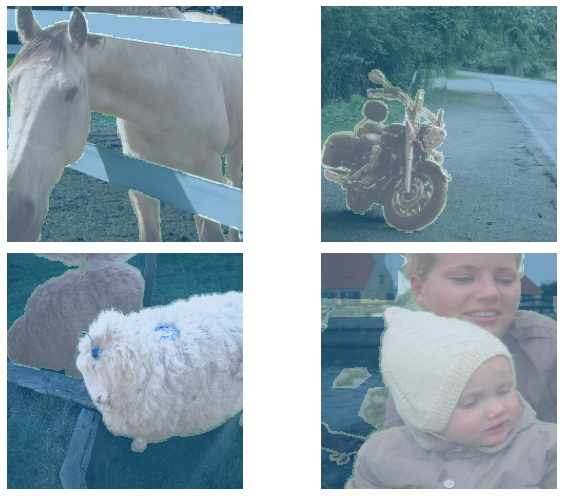

In [15]:
data.show_batch(rows=2,figsize=(10,7))

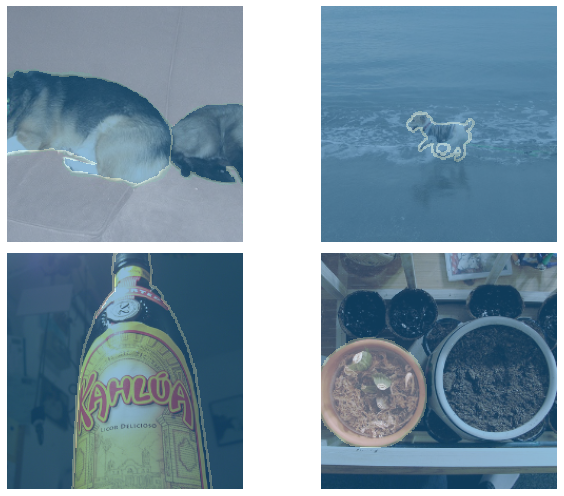

In [16]:
data.show_batch(rows=2,figsize=(10,7),ds_type=DatasetType.Valid)

In [17]:
def custom_loss(y_hat,y):
    y = y.squeeze(1)
    loss = nn.CrossEntropyLoss(ignore_index=255)
    return loss(y_hat,y)

    
def custom_acc(input,targs):
    targs = targs.squeeze(dim=1)
    input = input.argmax(dim=1)
    
    return (input.flatten()==targs.flatten()).float().mean()

Below is the code for the CRF layer

In [ ]:
class CrfRnnLayer(Layer):
    

    def __init__(self, image_dims, num_classes,
                 theta_alpha, theta_beta, theta_gamma,
                 num_iterations, **kwargs):
        self.image_dims = image_dims
        self.num_classes = num_classes
        self.theta_alpha = theta_alpha
        self.theta_beta = theta_beta
        self.theta_gamma = theta_gamma
        self.num_iterations = num_iterations
        self.spatial_ker_weights = None
        self.bilateral_ker_weights = None
        self.compatibility_matrix = None
        super(CrfRnnLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Weights of the spatial kernel
        self.spatial_ker_weights = self.add_weight(name='spatial_ker_weights',
                                                   shape=(self.num_classes, self.num_classes),
                                                   initializer=_diagonal_initializer,
                                                   trainable=True)

        # Weights of the bilateral kernel
        self.bilateral_ker_weights = self.add_weight(name='bilateral_ker_weights',
                                                     shape=(self.num_classes, self.num_classes),
                                                     initializer=_diagonal_initializer,
                                                     trainable=True)

        # Compatibility matrix
        self.compatibility_matrix = self.add_weight(name='compatibility_matrix',
                                                    shape=(self.num_classes, self.num_classes),
                                                    initializer=_potts_model_initializer,
                                                    trainable=True)

        super(CrfRnnLayer, self).build(input_shape)

    def call(self, inputs):
        unaries = tf.transpose(inputs[0][0, :, :, :], perm=(2, 0, 1))
        rgb = tf.transpose(inputs[1][0, :, :, :], perm=(2, 0, 1))

        c, h, w = self.num_classes, self.image_dims[0], self.image_dims[1]
        all_ones = np.ones((c, h, w), dtype=np.float32)

        # Prepare filter normalization coefficients
        spatial_norm_vals = custom_module.high_dim_filter(all_ones, rgb, bilateral=False,
                                                          theta_gamma=self.theta_gamma)
        bilateral_norm_vals = custom_module.high_dim_filter(all_ones, rgb, bilateral=True,
                                                            theta_alpha=self.theta_alpha,
                                                            theta_beta=self.theta_beta)
        q_values = unaries

        for i in range(self.num_iterations):
            softmax_out = tf.nn.softmax(q_values, 0)

            # Spatial filtering
            spatial_out = custom_module.high_dim_filter(softmax_out, rgb, bilateral=False,
                                                        theta_gamma=self.theta_gamma)
            spatial_out = spatial_out / spatial_norm_vals

            # Bilateral filtering
            bilateral_out = custom_module.high_dim_filter(softmax_out, rgb, bilateral=True,
                                                          theta_alpha=self.theta_alpha,
                                                          theta_beta=self.theta_beta)
            bilateral_out = bilateral_out / bilateral_norm_vals

            # Weighting filter outputs
            message_passing = (tf.matmul(self.spatial_ker_weights,
                                         tf.reshape(spatial_out, (c, -1))) +
                               tf.matmul(self.bilateral_ker_weights,
                                         tf.reshape(bilateral_out, (c, -1))))

            # Compatibility transform
            pairwise = tf.matmul(self.compatibility_matrix, message_passing)

            # Adding unary potentials
            pairwise = tf.reshape(pairwise, (c, h, w))
            q_values = unaries - pairwise

        return tf.transpose(tf.reshape(q_values, (1, c, h, w)), perm=(0, 2, 3, 1))

    def compute_output_shape(self, input_shape):
        return input_shape

Below I have changed the U-Net code of fastai to have atrous convolutions in the middle and CRF layer in the end

In [19]:
class DynamicUnet(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder:nn.Module, n_classes:int, img_size:Tuple[int,int]=(256,256), blur:bool=False, blur_final=True, self_attention:bool=False,
                 y_range:Optional[Tuple[float,float]]=None,
                 last_cross:bool=True, bottle:bool=False, **kwargs):
        imsize = img_size
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs], detach=False)
        x = dummy_eval(encoder, imsize).detach()

        ni = sfs_szs[-1][1]
        middle_conv = nn.Sequential(conv_layer_atrous(ni=ni, nf=ni*2, dilation=2, **kwargs),
                                    conv_layer_atrous(ni=ni*2, nf=ni, dilation=4, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, batchnorm_2d(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sfs_idxs):
            not_final = i!=len(sfs_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sfs_szs[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sfs_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
                                   **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sfs_szs[0][-2:]: layers.append(PixelShuffle_ICNR(ni, **kwargs))
        x = PixelShuffle_ICNR(ni)(x)
        if imsize != x.shape[-2:]: layers.append(Lambda(lambda x: F.interpolate(x, imsize, mode='nearest')))
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(res_block(ni, bottle=bottle, **kwargs))
        layers += [conv_layer(ni, n_classes, ks=1, use_activ=False, **kwargs)]
        x=CrfRnnLayer(image_dims=img_size,
                         num_classes=n_classes,
                         theta_alpha=160.,
                         theta_beta=3.,
                         theta_gamma=3.,
                         num_iterations=10,
                         name='crfrnn')([x, inputs])
        layers.append(CrfRnnLayer)
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()
def unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=None, split_on:Optional[SplitFuncOrIdxList]=None, blur:bool=False,
                 self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, last_cross:bool=True,
                 bottle:bool=False, cut:Union[int,Callable]=None, **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    meta = learner.cnn_config(arch)
    body = create_body(arch, pretrained, cut)
    try:    size = data.train_ds[0][0].size
    except: size = next(iter(data.train_dl))[0].shape[-2:]
    model = to_device(models.unet.DynamicUnet(body, n_classes=data.c, img_size=size, blur=blur, blur_final=blur_final,
          self_attention=self_attention, y_range=y_range, norm_type=norm_type, last_cross=last_cross,
          bottle=bottle), data.device)
    learn = Learner(data, model, **learn_kwargs)
    learn.split(ifnone(split_on, meta['split']))
    if pretrained: learn.freeze()
    apply_init(model[2], nn.init.kaiming_normal_)
    return learn


In [20]:
from fastai.vision import learner
learn = unet_learner(data,models.resnet34,metrics=custom_acc,loss_func=custom_loss)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


For this model we can see that the optimum learning rate is 1e-3 from below plot

epoch,train_loss,valid_loss,custom_acc,time


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


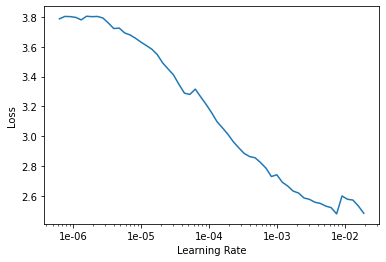

In [21]:
lr_find(learn)
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(4,slice(1e-3))

epoch,train_loss,valid_loss,custom_acc,time
0,1.285012,1.184481,0.662099,1:03:04
1,1.177498,1.113341,0.664072,1:03:12
2,0.926020,0.878411,0.709622,1:03:37
3,0.891115,0.817114,0.717048,1:04:56


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

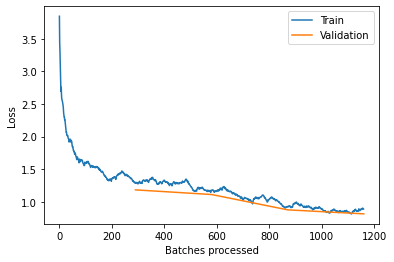

In [23]:
learn.recorder.plot_losses()

In [24]:
img = learn.data.valid_ds[0][0]
learn.predict(img)

(ImageSegment (1, 224, 224), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]), tensor([[[ 6.8380,  7.1483,  7.9192,  ...,  6.6161,  6.0051,  5.7492],
          [ 7.3051,  7.1687,  8.0231,  ...,  6.8031,  6.4508,  5.9329],
          [ 9.5441,  9.1774,  8.3882,  ...,  8.1852,  7.5107,  7.0416],
          ...,
          [ 3.9842,  3.8914,  4.1792,  ...,  5.3612,  5.7569,  5.6421],
          [ 3.7466,  3.8090,  3.8733,  ...,  5.9003,  5.4629,  5.3026],
          [ 3.5860,  3.6953,  3.8567,  ...,  6.1680,  5.5493,  5.3502]],
 
         [[-2.3601, -2.4353, -1.9361,  ..., -1.9627, -1.9771, -1.8282],
          [-2.5776, -2.3731, -1.9339,  ..., -2.1523, -1.9713, -1.7175],
          [-2.5831, -2.3427, -1.7869,  ..., -2.6077, -3.5157, -3.2182],
          ...,
          [-1.2577, -1.1231, -0.6543,  ..., -2.0153, -2.58

From the below predictions we can see that the model definitely performed well on the validation data compared to the other model. Here the images are segmented more accurately

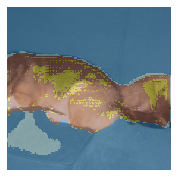

In [25]:
img.show(y=learn.predict(img)[0])

In [26]:
learn.save('stage-1_224',with_opt=False)

In [27]:
img = learn.data.valid_ds[2][0]

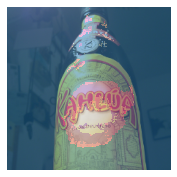

In [28]:
img.show(y=learn.predict(img)[0])

In [29]:
learn.export()

In [30]:
learn.load('stage-1_224',strict=False)

Learner(data=ImageDataBunch;

Train: LabelList (1160 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: zipped_VOC/VOCdevkit/VOC2012/JPEGImages;

Valid: LabelList (289 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: zipped_VOC/VOCdevkit/VOC2012/JPEGImages;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [31]:
img = open_image('/content/drive/MyDrive/zipped_VOC/VOCdevkit/VOC2012/JPEGImages/person_bicycle.jpg')

In [32]:
img.resize(size=224)
img.data.size()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


torch.Size([3, 224, 224])

Below is the prediction of the same image from the previous notebook, as you can see from the figure the segmentation is more accurate here

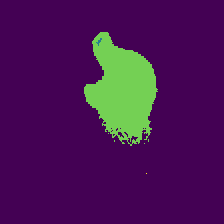

In [33]:
img_pred = learn.predict(img)
img_pred[0]

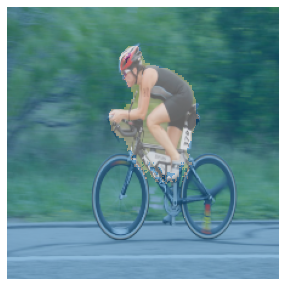

In [34]:
img.show(y=learn.predict(img)[0],figsize=(5,5))

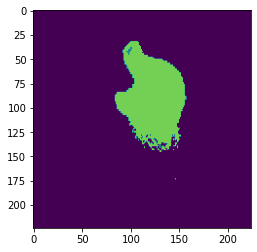

In [35]:
temp = np.array(learn.predict(img)[0].data)
temp = temp.squeeze()
plt.imshow(temp)
